In [2]:
import sys
#!{sys.executable} -m pip install xlrd

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
from cycler import cycler
import os
import xlrd
import scipy.optimize

save = True

if not save:
    plt.style.use('dark_background')
    plt.rcParams['figure.facecolor'] = "slategray"
    plt.rcParams['axes.facecolor'] = "slategray"

In [4]:
def findNumRuns(df):
    descriptor = df.columns[-1]
    return int(re.findall('(\d+)', descriptor)[0])

In [5]:
def lin(x, m, t):
    return m*x +t

def fitSubThreshold(params, axis, df, colors):
    config = params["fit_st"]
    ignore = params["ignore"] if "ignore" in params else []
    
    name_x = "{}(1)".format(params["x"])
    for i in config["idx"]:
        name_y = "{}({})".format(params["y"],i+1)
        fit_data = df[[name_x, name_y]]
        fit_data = fit_data[fit_data[name_x]>config["range"][0]] 
        fit_data = fit_data[fit_data[name_x]<config["range"][1]] 

        p, cv = scipy.optimize.curve_fit(lin, np.array(fit_data[name_x]), np.log(np.array(fit_data[name_y])))
        m, t = p
        color_correction = sum(i > v for v in ignore)
        axis.plot(fit_data[name_x], np.exp(lin(fit_data[name_x], m, t)), '--', label="S={:.1f}mV/dec".format(np.log(10)/m*1e3), c=colors[i-color_correction])
        axis.plot(fit_data[name_x], fit_data[name_y], '.', label = None, c=colors[i-color_correction])


def plotExperiment(params, axis):
    wb = xlrd.open_workbook("{}.xls".format(params["src"]), logfile=open(os.devnull, 'w'))
    df = pd.read_excel(wb)

    runs = findNumRuns(df)
    ignore = params["ignore"] if "ignore" in params else []

    colors = plt.cm.viridis(np.linspace(0, 1, runs-len(ignore)))
    mycycler = cycler(color=colors)
    axis.set_prop_cycle(mycycler)

    names = ["{}({})".format(params["y"],x+1) for x in range(runs) if x not in ignore]
    legend_keys = ["{}({})".format(params["legend"],x+1) for x in range(runs) if x not in ignore]

    df.plot(ax = axis, x="{}(1)".format(params["x"]), y=names, logy=params["logy"])
    axis.set_title(params["title"])
    axis.set_xlabel(name_mapping[params["x"]])
    axis.set_ylabel(name_mapping[params["y"]])
    axis.grid()
    if "ylim" in params:
        axis.set_ylim(params["ylim"])

    if "xlim" in params:
        axis.set_xlim(params["xlim"])

    if "fit_st" in params:
        fitSubThreshold(params, axis, df, colors)

    L=axis.legend(title=name_mapping[params["legend"]])
    for i, key in enumerate(legend_keys):
         L.get_texts()[i].set_text(round(df[key][0], 2))

    



In [6]:
def getAx(nx, ny, axs, i):
    return axs[i//nx, i%nx] if ny > 1 else axs[i]

def plotFromParams(params, savename = "tmp", nx = 6):
    ny = int(np.ceil(len(params)/nx))

    f, axs = plt.subplots(ny, nx, figsize = (35, ny*5))
    for i, p in enumerate(params):
        plotExperiment(p, getAx(nx, ny, axs, i))
        #plt.close()

    for i in range(len(params), nx*ny):
        f.delaxes(getAx(nx, ny, axs, i))
    
    plt.savefig("{}/{}.svg".format(folder, savename.replace(" ", "_")))

def plotSingle(params):
    f, ax = plt.subplots(figsize = (35/4, 5))
    plotExperiment(params, ax)
    plt.savefig("{}/{}.svg".format(folder, params["title"].replace(" ", "_")))

In [7]:
name_mapping = {"DrainI": "Drain current [A]", "GateV": "Gate voltage [V]", "DrainV": "Drain voltage [V]", "BulkV": "Program voltage [V]", "BulkI": "Program gate leakage [A]"}
folder = "plots"

## Gate control before and after a Forming Gas Anneal (FGA)

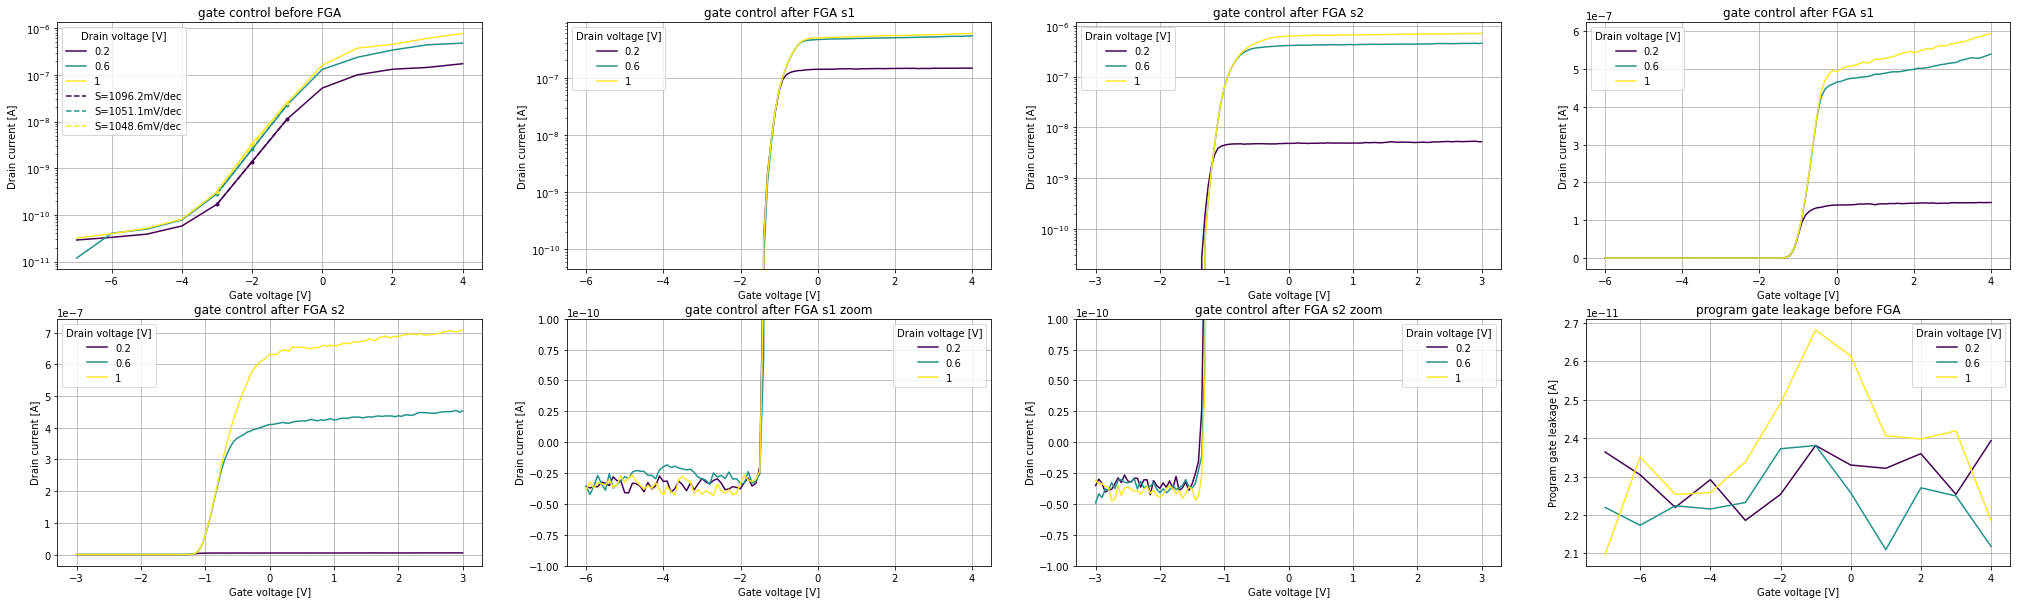

In [9]:
params = [
    {"src": "Group3/test11", "y": "DrainI", "x": "GateV", "legend": "DrainV", "title": "gate control before FGA", "logy": True, "fit_st":{"idx": [0,1,2], "range":(-3.5, -0.5)}},
    {"src": "Group3/After FGA/After_FGA/2-1/test11", "y": "DrainI", "x": "GateV", "legend": "DrainV", "title": "gate control after FGA s1", "logy": True},
    {"src": "Group3/After FGA/After_FGA/2-2/test11-2-2", "y": "DrainI", "x": "GateV", "legend": "DrainV", "title": "gate control after FGA s2", "logy": True},
    {"src": "Group3/After FGA/After_FGA/2-1/test11", "y": "DrainI", "x": "GateV", "legend": "DrainV", "title": "gate control after FGA s1", "logy": False},
    {"src": "Group3/After FGA/After_FGA/2-2/test11-2-2", "y": "DrainI", "x": "GateV", "legend": "DrainV", "title": "gate control after FGA s2", "logy": False},
    {"src": "Group3/After FGA/After_FGA/2-1/test11", "y": "DrainI", "x": "GateV", "legend": "DrainV", "title": "gate control after FGA s1 zoom", "logy": False, "ylim":[-1e-10, 1e-10]},
    {"src": "Group3/After FGA/After_FGA/2-2/test11-2-2", "y": "DrainI", "x": "GateV", "legend": "DrainV", "title": "gate control after FGA s2 zoom", "logy": False, "ylim":[-1e-10, 1e-10]},
    #{"src": "Group3/After FGA/After_FGA/2-2/test11-2-2", "y": "BulkI", "x": "GateV", "legend": "DrainV", "title": "program gate leakage after FGA s2", "logy": False},
    {"src": "Group3/test11", "y": "BulkI", "x": "GateV", "legend": "DrainV", "title": "program gate leakage before FGA", "logy": False},
]
plotFromParams(params, nx=4)
plt.savefig("gatecontrol.png")

### same plots Group1

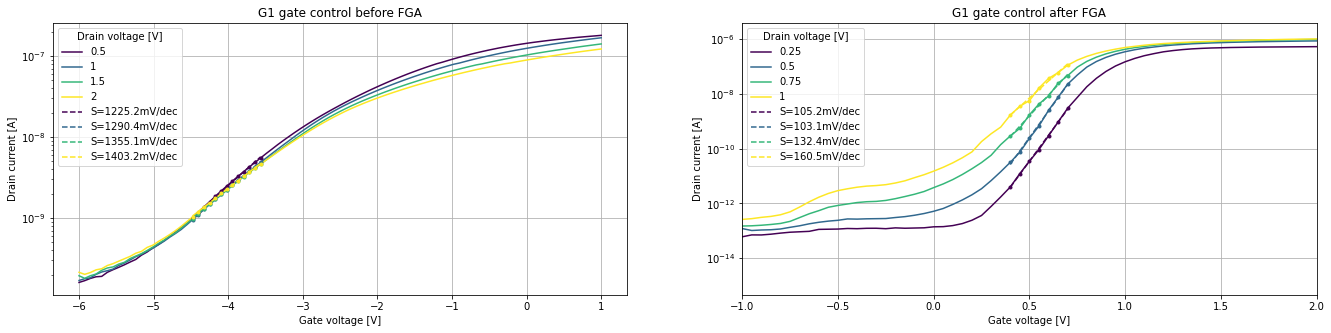

In [137]:
params = [
    {"src": "Group1/cmos_sample1_6", "y": "DrainI", "x": "GateV", "legend": "DrainV", "title": "G1 gate control before FGA", "logy": True, "fit_st":{"idx": [0,1,2,3], "range":(-4.5, -3.5)}},
    {"src": "Group1/afterFGA/cmos_device3-3_fga_bulk4V_idvgs", "y": "DrainI", "x": "GateV", "legend": "DrainV", "title": "G1 gate control after FGA", "logy": True, "ignore":[0], "fit_st":{"idx": [1,2,3,4], "range":(0.4, 0.7)}, "xlim":[-1,2]}
]
plotFromParams(params, nx = 3)    

## Output characteristic

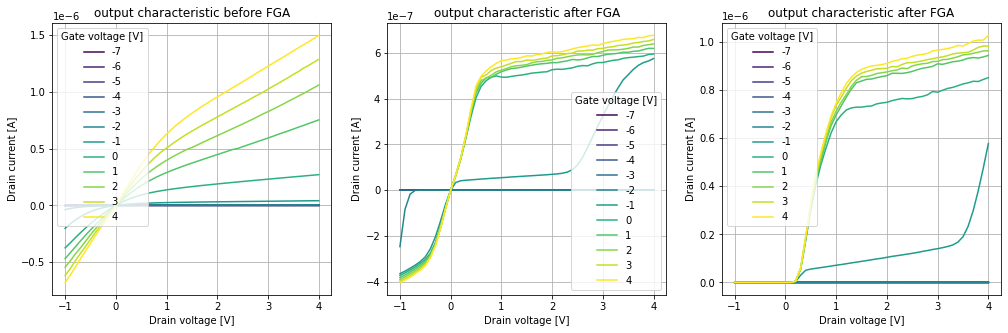

In [ ]:
params = [
    {"src": "Group3/test12", "y": "DrainI", "x": "DrainV", "legend": "GateV", "title": "output characteristic before FGA", "logy": False},
    {"src": "Group3/After FGA/After_FGA/2-1/test12", "y": "DrainI", "x": "DrainV", "legend": "GateV", "title": "output characteristic after FGA", "logy": False},
    {"src": "Group3/After FGA/After_FGA/2-2/test12", "y": "DrainI", "x": "DrainV", "legend": "GateV", "title": "output characteristic after FGA", "logy": False},
    #{"src": "Group3/After FGA/After_FGA/2-1/new1", "y": "DrainI", "x": "DrainV", "legend": "GateV", "title": "output characteristic after LGA extended", "logy": False},
]

plotFromParams(params)

### same Group1

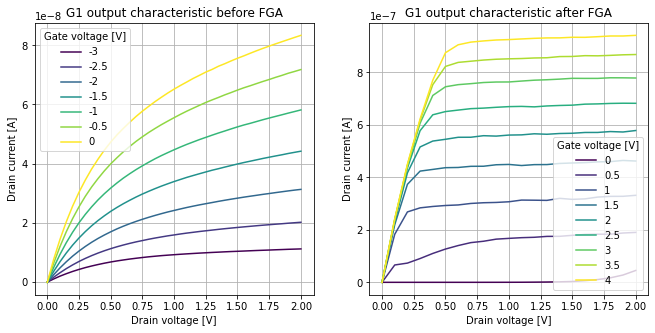

In [ ]:
params = [
    {"src": "Group1/cmos_sample1_bulkV_0V", "y": "DrainI", "x": "DrainV", "legend": "GateV", "title": "G1 output characteristic before FGA", "logy": False},
    {"src": "Group1/afterFGA/cmos_device3-3_fga_bulk0V", "y": "DrainI", "x": "DrainV", "legend": "GateV", "title": "G1 output characteristic after FGA", "logy": False},
]

plotFromParams(params)

## Sweep of the program gate

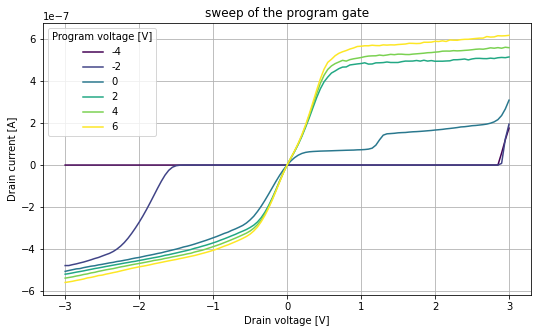

In [ ]:
params = [
    {"src": "Group3/After FGA/After_FGA/2-1/programsweep", "y": "DrainI", "x": "DrainV", "legend": "BulkV", "title": "sweep of the program gate", "logy": False, "ignore": [1,3,5,7,9,11]},
]

plotSingle(params[0])